In [1]:
import copy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

from loader.DataLoader import read_dataframe
from loader.DataTransformer import lag_list, transform_matrix

from model.RandomForestLstmModel import RandomForestLstmModel
from model.ScalingResidualLstmModel import ScalingResidualLstmModel
# from model.LstmModel import LstmModel

In [2]:
import matplotlib.pyplot as plt

In [3]:
# data parameter
LAG = 15
WAVE = 1

### Prepare Data

In [4]:
def get_file_path(wave, filename):
#     curr_dir = os.getcwd()
#     project_dir = curr_dir.split('GitHub')[0]
#     analysis_on_covid_dir = os.path.join(project_dir, 'GitHub', 'analysis-on-covid')
#     return analysis_on_covid_dir + 'checkpoint_wave' + str(wave) + '/' + filename
    return 'checkpoint_wave' + str(wave) + '/' + filename

In [5]:
def get_wave_period(wave: int):
    if wave == 1:
        return (52, 103)
    elif wave == 2:
        return (160, 280)
    elif wave == 3:
        return (280, 505)
    elif wave == 4:
        return (757, 871)

In [6]:
def std_column(df: pd.DataFrame, column_name: str)->pd.DataFrame:
    if (df[column_name] == 0).all():
        return df[column_name]
    return (df[column_name] - df[column_name].mean()) / df[column_name].std()

In [7]:
# prepare data
wave_start, wave_end = get_wave_period(WAVE)

sequence = read_dataframe('all')
sequence = sequence[wave_start - LAG: wave_end]

count_mean = sequence.mean()['count']
count_std = sequence.std()['count']

for _ in ['avg_temp', 'avg_humid', 'sum', 'count']:
    sequence[_] = std_column(sequence, _)
    
shifted_sequence = lag_list(sequence, LAG + 1)  # shift into delayed sequences

x_train = shifted_sequence[:, :-1, 1:]  # for each delayed sequence, take all elements except last element
y_train = shifted_sequence[:, -1, -1]  # for each delayed sequence, only take the last element
y_train = y_train.reshape(-1, 1)

x_train = torch.from_numpy(x_train.astype('float64')).type(torch.Tensor)  # convert to tensor
y_train = torch.from_numpy(y_train.astype('float64')).type(torch.Tensor)  # convert to tensor

### Model

In [8]:
class LstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0):
        super(LstmModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step output and pass it through a fully connected layer
        return out

In [9]:
class CurveLoss(nn.MSELoss):
    def __init__(self, model, lambda_l1, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)
        self.model = model
        self.lambda_l1 = lambda_l1

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        l1_penalty = 0
        for param in self.model.parameters():
            l1_penalty += torch.sum(torch.abs(param))
        return super().forward(input, target) + torch.square(torch.mean(torch.abs(input - target))) + self.lambda_l1 * l1_penalty

In [10]:
# build model
input_dim = x_train.shape[-1]
hidden_dim = 64
num_layers = 4
output_dim = 1

# model = LstmModel(input_dim, hidden_dim, num_layers, output_dim, LAG)
model = LstmModel(input_dim, hidden_dim, num_layers, output_dim)
num_epochs = 3_000
loss_fn = CurveLoss(model, 1e-5)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
min_loss = np.inf
best_model_state = None
model.train()

LstmModel(
  (lstm): LSTM(22, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
TRAIN_RANGE = y_train.shape[0]

for epoch in range(1, num_epochs + 1):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    if epoch % 100 == 0:
        print("Epoch: %d | MSE: %.2E | RMSE: %.2E" % (epoch, loss.item(), np.sqrt(loss.item())))
    if min_loss > loss.item():
        best_model_state = copy.deepcopy(model.state_dict())
        min_loss = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch: 100 | MSE: 1.89E-01 | RMSE: 4.35E-01
Epoch: 200 | MSE: 1.22E-01 | RMSE: 3.49E-01
Epoch: 300 | MSE: 7.84E-02 | RMSE: 2.80E-01
Epoch: 400 | MSE: 6.96E-02 | RMSE: 2.64E-01
Epoch: 500 | MSE: 6.29E-02 | RMSE: 2.51E-01
Epoch: 600 | MSE: 5.85E-02 | RMSE: 2.42E-01
Epoch: 700 | MSE: 5.33E-02 | RMSE: 2.31E-01
Epoch: 800 | MSE: 4.81E-02 | RMSE: 2.19E-01
Epoch: 900 | MSE: 4.43E-02 | RMSE: 2.11E-01
Epoch: 1000 | MSE: 4.16E-02 | RMSE: 2.04E-01
Epoch: 1100 | MSE: 3.97E-02 | RMSE: 1.99E-01
Epoch: 1200 | MSE: 3.82E-02 | RMSE: 1.95E-01
Epoch: 1300 | MSE: 3.57E-02 | RMSE: 1.89E-01
Epoch: 1400 | MSE: 3.41E-02 | RMSE: 1.85E-01
Epoch: 1500 | MSE: 3.28E-02 | RMSE: 1.81E-01
Epoch: 1600 | MSE: 3.10E-02 | RMSE: 1.76E-01
Epoch: 1700 | MSE: 2.95E-02 | RMSE: 1.72E-01
Epoch: 1800 | MSE: 2.84E-02 | RMSE: 1.69E-01
Epoch: 1900 | MSE: 2.80E-02 | RMSE: 1.67E-01
Epoch: 2000 | MSE: 2.67E-02 | RMSE: 1.64E-01
Epoch: 2100 | MSE: 2.59E-02 | RMSE: 1.61E-01
Epoch: 2200 | MSE: 2.51E-02 | RMSE: 1.58E-01
Epoch: 2300 | MSE: 

In [12]:
# for the first day's input, the prediction is real.  
# that is to kickstart the ongoing prediction

x_test = x_train[0].reshape(1,LAG, x_train.shape[2]) # get the first input
y_pred = [ x_test[0][-1][0].detach().numpy().reshape(-1) ] # initialize the list with the first actual count

prediction_range = len(x_train)
# prediction_range = 7

for i in range(1, prediction_range):
    _ = model(x_test)
    
    # extract the next input item
    x_test = x_train[i].reshape(1, LAG, x_train.shape[2])
    
    # modify the previous day's count to be the prediction
    x_test[0][-1][0] = torch.tensor(_.item())
    
    # append to model prediction list
    _2 = _.detach().numpy()  # revert from tensor
    _2 = _2.reshape(-1)  # reshape back to normal list
    y_pred.append(_2)

In [13]:
len(x_train)

51

In [14]:
y_pred = np.array(y_pred).reshape(-1)  # reshape back to normal list
y_train = np.array(y_train).reshape(-1)  # reshape back to normal list

In [15]:
y_pred[:10]

array([ 0.0266892 , -0.7649459 , -0.7631542 , -0.7613298 , -0.758697  ,
       -0.75464815, -0.7476911 , -0.73470044, -0.7064795 , -0.6466742 ],
      dtype=float32)

In [16]:
y_train[:10]

array([-0.864286  , -0.6882278 , -0.74691385, -0.8055999 , -0.6882278 ,
       -0.8055999 , -0.74691385, -0.74691385, -0.57085556, -0.74691385],
      dtype=float32)

In [17]:
mse = sum((y_train - y_pred) ** 2) / len(y_pred)
rmse = mse / np.var(y_train)
print("TEST | MSE: %.2E | RMSE: %.2E" % (mse, rmse))

TEST | MSE: 2.82E-01 | RMSE: 2.61E-01


### Plot Result

In [18]:
# adjustment for accumulated data
adjustment_factor = 1 - rmse * rmse
print("adjustment factor %.2f" % adjustment_factor)
y_pred *= adjustment_factor

adjustment factor 0.93


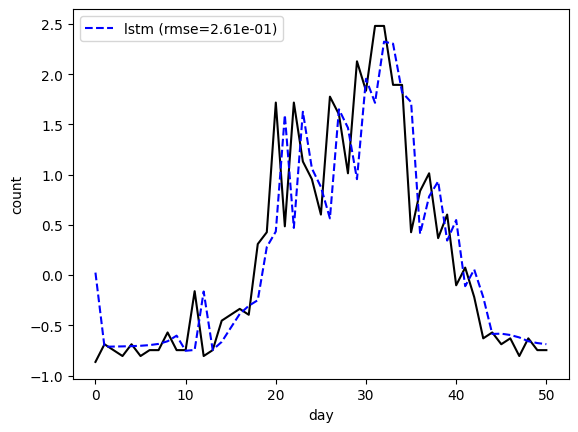

In [19]:
plt.plot(range(len(y_train)), y_train, color='black')
plt.plot(range(len(y_pred)), y_pred, 'b--', label='lstm (rmse={rmse:.2e})'.format(rmse=rmse))
plt.ylabel("count")
plt.xlabel("day")
plt.legend()
plt.show()

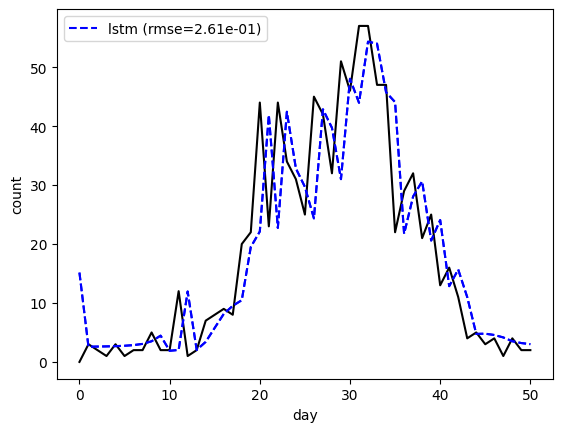

In [20]:
y_train_ori = y_train * count_std + count_mean
y_pred_ori = y_pred * count_std + count_mean

plt.plot(range(len(y_train_ori)), y_train_ori, color='black')
plt.plot(range(len(y_pred_ori)), y_pred_ori, 'b--', label='lstm (rmse={rmse:.2e})'.format(rmse=rmse))
plt.plot(range(len(y_pred_ori)), y_pred_ori, 'b--')
plt.ylabel("count")
plt.xlabel("day")
plt.legend()
plt.show()